In [698]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [699]:
#load data
data = pd.read_csv('train/combined.csv', index_col=0)

X = data.drop(['right_touch', 'left_touch'], axis=1)
y = data[['right_touch', 'left_touch']]

X_train = X
y_train = y

data = pd.read_csv('train/demo_walk_9_train.csv', index_col=0)

X = data.drop(['right_touch', 'left_touch'], axis=1)
y = data[['right_touch', 'left_touch']]

X_test = X
y_test = y

# Use train_test_split with stratify parameter
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convert pandas DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [700]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

input_size = X_train.shape[1]
hidden_size = 64  # You can adjust this based on your problem
output_size = 2  # Assuming binary classification for each foot

# Instantiate the model
model = NN(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [701]:
# Convert data to DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [702]:
num_epochs = 120

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss for every epoch
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch [10/120], Loss: 0.3842
Epoch [20/120], Loss: 0.1219
Epoch [30/120], Loss: 0.2070
Epoch [40/120], Loss: 0.3432
Epoch [50/120], Loss: 0.1167
Epoch [60/120], Loss: 0.2473
Epoch [70/120], Loss: 0.1274
Epoch [80/120], Loss: 0.1367
Epoch [90/120], Loss: 0.0734
Epoch [100/120], Loss: 0.2525
Epoch [110/120], Loss: 0.0493
Epoch [120/120], Loss: 0.0783
Test Loss: 0.1641


In [703]:
#predict on train set
with torch.no_grad():
    model.eval()
    train_outputs = model(X_train_tensor)
    train_loss = criterion(train_outputs, y_train_tensor)
    print(f'Train Loss: {train_loss.item():.4f}')
    

Train Loss: 0.1452


In [704]:
#plot output
# plt.figure(figsize=(8, 6))
# plt.plot(train_outputs[:, 0], label='Predicted Right')
# plt.plot(y_train_tensor[:, 0], label='Actual Right')
# plt.legend()
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.plot(train_outputs[:, 1], label='Predicted Left')
# plt.plot(y_train_tensor[:, 1], label='Actual Left')
# plt.legend()
# plt.show()


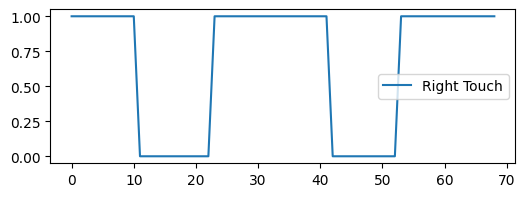

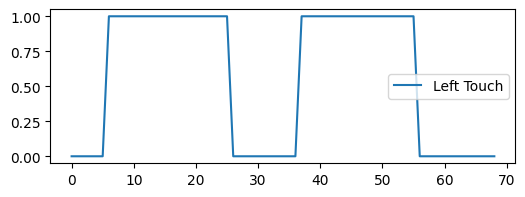

In [726]:
#predict on full set
X_full = torch.tensor(X_test.values, dtype=torch.float32)
X_full_outputs = model(X_full)
X_np = X_full_outputs.detach().numpy()

#plot output
plt.figure(figsize=(6, 2))
# plt.plot(X_np[:, 0], label='Predicted Right')
plt.plot(y.right_touch, label='Right Touch')
plt.legend()

plt.figure(figsize=(6, 2))
# plt.plot(X_np[:, 1], label='Predicted Left')
plt.plot(y.left_touch, label='Left Touch')
plt.legend()
plt.show()


In [706]:
#get accuracy on test set
y_pred = np.round(X_np)
y_actual = y_test.values
# print(y_pred)
# print(y_actual)
print(np.sum(y_pred == y_actual) / y_actual.size)

0.9347826086956522


In [707]:
#get baseline accuracy
y_baseline = np.ones(y_actual.shape)
print(np.sum(y_baseline == y_actual) / y_actual.size)

0.6159420289855072


In [708]:
#cut the last 10 frames
y_pred = np.round(X_np[:-10])
y_actual = y_test.values[:-10]
# print(y_pred)
# print(y_actual)
print(np.sum(y_pred == y_actual) / y_actual.size)


0.923728813559322


In [709]:
#round predictions
X_full_outputs_round = torch.round(X_full_outputs)

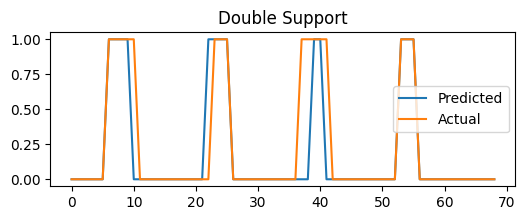

In [710]:
#calculate double support by looking at when both feet are touching (1,1)
ds = []
for i in range(len(X_full_outputs_round)):
    if X_full_outputs_round[i][0] == 1 and X_full_outputs_round[i][1] == 1:
        ds.append(1)
    else:
        ds.append(0)

ds_true = []
for i in range(len(y)):
    if y.right_touch[i] == 1 and y.left_touch[i] == 1:
        ds_true.append(1)
    else:
        ds_true.append(0)

#plot double support
plt.figure(figsize=(6, 2))
plt.plot(ds, label='Predicted')
plt.plot(ds_true, label='Actual')
plt.legend()
plt.title('Double Support')
plt.show()


In [711]:
#calculate percentege of 1s in predictions
print('Predicted Double Support:', sum(ds)/len(ds))
print('Actual Double Support:', sum(ds_true)/len(ds_true))

Predicted Double Support: 0.18840579710144928
Actual Double Support: 0.2318840579710145


In [712]:
import joblib

#load original data
track_dict = joblib.load('data/demo_walk_19.pkl')

def get_cameras(dict):
    frames = list(dict.keys())
    joints_2d = []
    for frame in frames:
        joints_2d.append(dict.get(frame).get('camera'))
    
    return np.array(joints_2d)

In [713]:
camera_frames = get_cameras(track_dict).reshape(get_cameras(track_dict).shape[0], -1)
x_coords = camera_frames

In [714]:
left_touch_pred = X_full_outputs_round[:, 1].detach().numpy()
right_touch_pred = X_full_outputs_round[:, 0].detach().numpy()

In [715]:
#make a function that given a list of 1s and 0s, returns the indices where the current value is 1 and the previous value is 0
def get_touches(touch_list):
    touches = []
    for i in range(len(touch_list)):
        if touch_list[i] == 1 and touch_list[i-1] == 0:
            touches.append(i)
    return touches

In [716]:
touches_left = get_touches(left_touch_pred)
touches_right = get_touches(right_touch_pred)

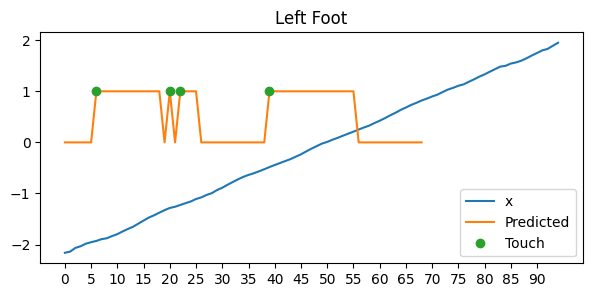

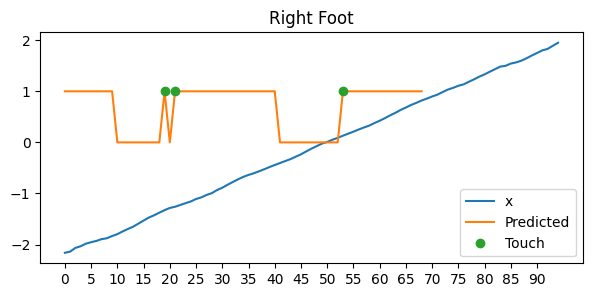

In [717]:
#plot right foot
plt.figure(figsize=(7, 3))
plt.plot(x_coords[:, 0], label='x')
plt.plot(left_touch_pred, label='Predicted')
plt.plot(touches_left, [1]*len(touches_left), 'o', label='Touch')
#plot x ticks every 5
plt.xticks(np.arange(0, len(x_coords[:, 0]), 5))
plt.legend()
plt.title('Left Foot')
plt.show()

#plot right foot
plt.figure(figsize=(7, 3))
plt.plot(x_coords[:, 0], label='x')
plt.plot(right_touch_pred, label='Predicted')
plt.plot(touches_right, [1]*len(touches_right), 'o', label='Touch')
#plot x ticks every 5
plt.xticks(np.arange(0, len(x_coords[:, 0]), 5))
plt.legend()
plt.title('Right Foot')
plt.show()

In [718]:
print('Left Touches:', touches_left)
print('Right Touches:', touches_right)


Left Touches: [6, 20, 22, 39]
Right Touches: [19, 21, 53]


In [719]:
# touches_left.remove(37)

In [720]:
#get the stride length by subtracting the x coordinates with the next touch of the same foot
stride_length_right = x_coords[touches_right[1:], 0] - x_coords[touches_right[:-1], 0]
stride_length_left = x_coords[touches_left[1:], 0] - x_coords[touches_left[:-1], 0]

#remove values below 0.3
stride_length_right = stride_length_right[stride_length_right > 0.3]
stride_length_left = stride_length_left[stride_length_left > 0.3]

#remove the first stride length because it is not a full stride
# stride_length_right = stride_length_right[1:]
# stride_length_left = stride_length_left[1:] 

avg_stride_length_right = np.abs(np.mean(stride_length_right))
avg_stride_length_left = np.abs(np.mean(stride_length_left))

print('Stride Length Right:', avg_stride_length_right)
print('Stride Length Left:', avg_stride_length_left)


Stride Length Right: 1.3911409
Stride Length Left: 0.6939584


In [721]:
#print the percent difference between the left and right stride lengths
diff = np.abs(avg_stride_length_right - avg_stride_length_left)/((avg_stride_length_right + avg_stride_length_left)/2)
diff*100

66.87284032775564

In [722]:
#get the walking speed by subtracting the first and last x coordinates and dividing by the number of frames
walking_speed = abs(x_coords[-1, 0] - x_coords[0, 0]) / (len(x_coords)/30)
walking_speed

1.298344561928197